In [1]:
#%matplotlib widget

In [2]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
sys.path.append('d:/ariel2/code/core/')
sys.path.append('/kaggle/input/my-ariel2-library')
import kaggle_support as kgs
import ariel_model
import ariel_simple
import ariel_simple2
import ariel_gp
import ariel_load
import ariel_load_FGS
import ariel_pca
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import importlib
from tqdm import tqdm
import seaborn as sns
import pandas as pd
kgs.debugging_mode = 1
kgs.profiling=False
kgs.n_workers = 6

local


In [3]:
train_data = kgs.load_all_train_data()
train_data = train_data

# t = []
# for ind in range(len(train_data)):
#     if ind not in [999, 114, 21, 647, 146, 147, 897, 364, 553, 1013, 264, 90, 931, 697, 501, 288, 689, 892, 64, 251, 298, 876, 886, 494, 220, 398, 16, 727, 277, 1067, 1021, 240, 1002, 809, 460, 665, 679, 729, 1049, 989, 383, 531, 305, 1025, 401, 838, 99, 163, 1055, 695, 894, 750, 111, 418, 328, 403, 680, 171, 683, 877, 761, 765, 956, 119, 618, 216, 60, 9, 0, 159, 1091, 112, 422, 885, 229, 140, 568, 787, 11, 686, 563, 53, 1063, 636, 107, 737, 700, 795, 646, 1022, 712, 375, 333, 516, 185, 441, 656, 237, 262, 306, 408, 992, 893, 869, 954, 978, 285, 487, 601, 642, 245, 72, 484, 582, 1065, 933, 129, 591, 476, 393, 430, 784, 373, 722, 965, 263, 366, 379, 807, 479, 570, 349, 760, 782, 184, 1030, 998, 546, 337, 888, 477, 547, 23, 371, 678, 311, 669, 440, 505, 196, 720, 425, 75, 174, 44, 969, 100, 78, 120, 475, 578, 361, 536, 653, 688, 810, 1058, 213, 294, 96, 1031, 758, 708, 733, 362, 135, 734, 847, 485, 619, 17, 709, 161, 823, 826, 677, 152, 794, 1028, 812, 739, 1001, 907, 19, 879, 698, 202, 192, 793, 1024, 467, 803, 870, 66, 178, 416, 801, 816, 658, 592, 249, 439, 663, 160, 1047, 492, 786, 74, 604, 993, 219, 673, 593, 59, 836, 1088, 1075, 325, 588, 208, 151, 961, 913, 873, 321, 740, 951, 1066, 514, 271, 799, 137, 206, 675, 518, 724, 508, 341, 735, 387, 555, 864, 935, 538, 815, 198, 180, 549, 820, 327, 93, 899, 390, 667, 117, 903, 1057, 906, 701, 87, 909, 470, 421, 449, 290, 47, 88, 641, 783, 270, 754, 128, 703, 404, 845, 1004, 385, 314, 842, 1027, 606, 378, 228, 257, 101, 338, 193, 1000, 829, 519, 529, 156, 209, 13, 497, 1046, 438, 230, 624, 704, 970, 496, 164, 772, 70, 692, 384, 736, 824, 1094, 136, 948, 1051, 639, 901, 307, 912, 650, 1054, 696, 279, 169, 199, 22, 1042, 269, 201, 796, 278, 1036, 941, 891, 396, 716, 410, 920, 575, 255, 778, 1081, 925, 562, 963, 372, 367, 212, 567, 1038, 472, 571, 730, 153, 916, 144, 942, 442, 1095, 613, 1092, 713, 92, 1079, 910, 166, 89, 629, 2, 884, 177, 651, 447, 702, 655, 344, 203, 725, 412, 319, 622, 602, 572, 108, 448, 27, 217, 323, 461, 149, 865, 975, 18, 83, 875, 973, 530, 62, 732, 145, 603, 915, 902, 950, 431, 972, 97, 959, 693, 415, 246, 839, 874, 1093, 343, 28, 905, 286, 86, 445, 738, 871, 611, 962, 503, 806, 856, 292, 468, 256, 539, 122, 348, 459, 515, 707, 374, 466, 1015, 493, 825, 881, 1084, 615, 46, 31, 58, 427, 576, 500, 747, 797, 483, 790, 406, 690, 889, 197, 79, 805, 977, 605, 517, 155, 682, 559, 581, 423, 315, 284, 76, 830, 310, 313, 7, 946, 513, 584, 347, 560, 1006, 932, 649, 1052, 424, 138, 26, 247, 749, 640, 955, 533, 580, 499, 1034, 666, 200, 785, 1040, 645, 1041, 545, 317, 345, 30, 543, 952, 259, 8, 464, 296, 148, 369, 187, 995, 242, 880, 426, 322, 757, 1087, 607, 450, 743, 14, 167, 265, 1008, 131, 69, 471, 55, 126, 1062, 91, 481, 831, 486, 623, 726, 985, 35, 282, 173, 346, 186, 1043, 37, 990, 1048, 813, 670, 746, 1017, 363, 252, 504, 612, 32, 718, 569, 326, 768, 866, 1064, 110, 631, 420, 332, 142, 20, 643, 1016, 742, 443, 984, 986, 1069, 828, 551, 510, 316, 234, 921, 261, 744, 764, 851, 154, 859, 561, 1020, 583, 253, 940, 821, 684, 254, 832, 699, 846, 918, 50, 949, 565, 172, 81, 473, 42, 506, 1053, 896, 634, 488, 706, 774, 113, 710, 352, 376, 526, 1039, 857, 1086, 304, 862, 1050, 1083, 218, 957, 48, 127, 102, 280, 51, 895, 359, 858, 238, 1090, 324, 105, 930, 776, 210, 1071, 632, 741, 444, 405, 944, 339, 791, 964, 971, 745, 189, 370, 293, 224, 1033, 437, 960, 241, 759, 236, 115, 1023, 861, 301, 509, 586, 103, 190, 715, 239, 451, 205, 77, 150, 434, 104, 409, 756, 157, 927, 853, 924, 1056, 121, 223, 250, 318, 56, 542, 1, 751, 600, 608, 926, 994, 878, 1011, 226, 585, 635, 182, 436, 541, 522, 266, 482, 227, 132, 819, 911, 779, 798, 388, 134, 1098, 287, 162, 15, 1035, 52, 65, 395, 94, 773, 843, 1096, 934, 685, 480, 428, 590, 235, 867, 130, 728, 175, 433, 243, 106, 868, 399, 1029, 411, 456, 633, 616, 368, 281, 674, 900, 637, 498, 1072, 827, 57, 188, 143, 664, 354, 991, 158, 817, 534, 351, 392, 495, 25, 630, 380, 24, 676, 802, 1007, 231, 29, 947, 1018, 1073, 248, 232, 939, 863, 850, 691, 587, 356, 1085, 489, 33, 4, 407, 195, 943, 1070, 54, 579, 609, 835, 917, 353, 457, 520, 537, 748, 833, 837, 276, 469, 525, 980, 1019, 40, 1089, 465, 771, 272, 331, 80, 966, 6, 299, 852, 511, 808, 233, 68, 781, 67, 919, 260, 413, 769, 302, 654, 139, 183, 303, 557, 360, 532, 308, 41, 1009, 890, 453, 694, 458, 723, 12, 979, 1082, 312, 714, 168, 540, 49, 620, 860, 381, 717, 267, 594, 804, 1044, 377, 770, 141, 854, 336, 342, 898, 400, 883, 814, 84, 626, 625, 659, 752, 507, 61, 904, 391, 268, 211, 512, 221, 283, 687, 124, 3, 116, 638, 958, 614, 214, 1074, 179, 988, 953, 454, 844, 822, 98, 1037, 1060, 660, 358, 222, 181, 573, 258, 340, 382, 1014, 767, 1026, 550, 225, 937, 45, 291, 355, 191, 194, 922, 762, 300, 320, 766, 274, 474, 389, 661, 657, 295, 1068, 564, 1059, 10, 502, 711, 908, 297, 1078, 841, 1061, 165, 628, 544, 527, 789, 95, 478, 82, 71, 719, 753, 244, 981, 419, 983, 402, 929, 800, 763, 455, 668, 968, 974, 662, 914, 528, 34, 840, 617, 463, 599, 435, 535, 207, 36, 491, 63, 597, 627, 432, 446, 621, 462, 610, 644, 574, 882, 589, 275, 133, 386, 1005, 872, 125, 566, 5, 523, 524, 123, 452, 834, 1076, 1032, 777, 938, 848, 681, 43, 554, 204, 928, 976, 982, 577, 775, 987, 996, 923, 671, 170, 731, 855, 397, 109, 755, 1080, 705, 38]:
#         t.append(train_data[ind])
#         #print(ind)
# train_data = t[:6]
# train_data_multi = []
# train_data_single = []
# for d in train_data:
#     if len(d.transits)==1:
#         train_data_single.append(d)
#     else:
#         train_data_multi.append(d)
# len(train_data_multi), len(train_data_single)

# train_data = train_data_multi

In [13]:
importlib.reload(ariel_model)
import ariel_pca
importlib.reload(ariel_pca)
todo = dict()

# model = ariel_model.baseline_model()
# model.model.run_in_parallel = True
# todo['New baseline'] = model

# model = ariel_model.baseline_model()
# model.model.run_in_parallel = True
# model.model.starter_model.model.do_regularization = False
# def modify_func(model, cc):
#         import numpy as np
#         model.m['signal'].m['main'].m['transit'].cov_override = cc[0]
#         model.m['signal'].m['main'].m['transit'].mu_override = cc[1]
#         model.m['signal'].m['main'].m['transit'].std_values[-3] = 0.01
#         return model
# model.model.model_options.modify_func = modify_func
# model.model.model_options.modify_func_input = kgs.dill_load(kgs.temp_dir+'transit_model_tuning_Rp_fudge_28.pickle')
# model.model.starter_model.model.expose_Rp_fudge = True
# todo['Expose Rp fudge, new reg'] = model


# for ii in [2,10]:

#     model = ariel_model.baseline_model()
#     model.model = ariel_pca.PCA(model=model.model, n_components=ii)
#     model.model.model_options_link = model.model.model.model_options
#     model.model.model.run_in_parallel = True
#     todo['PCA'+str(ii)] = model
    
for ii in [2,3,6]:

    model = ariel_model.baseline_model()
    model.model = ariel_pca.PCA(model=model.model, n_components=ii)
    model.model.model_options_link = model.model.model.model_options
    model.model.ignore_FGS = True
    model.model.model.run_in_parallel = True
    todo['PCA'+str(ii) + ' no FGS'] = model
    
model = ariel_model.baseline_model()
model.model = ariel_pca.PCA(model=model.model, n_components=3)
model.model.model_options_link = model.model.model.model_options
model.model.ignore_FGS = True
model.model.rescale = True
model.model.filter_ratio = 0.6
model.model.model.run_in_parallel = True
todo['PCA3, no FGS, rescale 0.6'] = model

# model = ariel_model.baseline_model()
# model.model.run_in_parallel = True
# model.model.starter_model.model.do_regularization = False
# def modify_func(model, cc):
#         import numpy as np
#         model.m['signal'].m['main'].m['transit'].cov_override = cc[0]
#         model.m['signal'].m['main'].m['transit'].mu_override = cc[1]
#         model.m['signal'].m['main'].m['transit'].std_values[-3] = np.nan
#         return model
# model.model.model_options.modify_func = modify_func
# model.model.model_options.modify_func_input = (None,None)
# todo['No regularization'] = model

Sanity checks off!
PCA2 no FGS
Score:           0.6395
RMS error FGS:   176.95381 ppm
mRMS error FGS:  49.17191 ppm
RMS error AIRS:  148.84194 ppm
mRMS error AIRS: 51.52673 ppm
RMS error AIRSv: 63.16145 ppm
mRMS error AIRSv:33.26288 ppm
(0.6394791776366413, 0.00017695381101481706, 0.00014884193729224575)
PCA3 no FGS
Score:           0.6442
RMS error FGS:   177.99670 ppm
mRMS error FGS:  48.91289 ppm
RMS error AIRS:  147.12815 ppm
mRMS error AIRS: 46.79901 ppm
RMS error AIRSv: 59.55848 ppm
mRMS error AIRSv:28.09981 ppm
(0.6442074811996894, 0.00017799670272662584, 0.00014712815496926044)
PCA6 no FGS
Score:           0.6448
RMS error FGS:   177.19690 ppm
mRMS error FGS:  49.05198 ppm
RMS error AIRS:  143.17146 ppm
mRMS error AIRS: 45.83454 ppm
RMS error AIRSv: 49.22284 ppm
mRMS error AIRSv:27.66648 ppm
(0.6448400324612993, 0.00017719690413570333, 0.00014317145536399747)
PCA3, no FGS, rescale 0.6


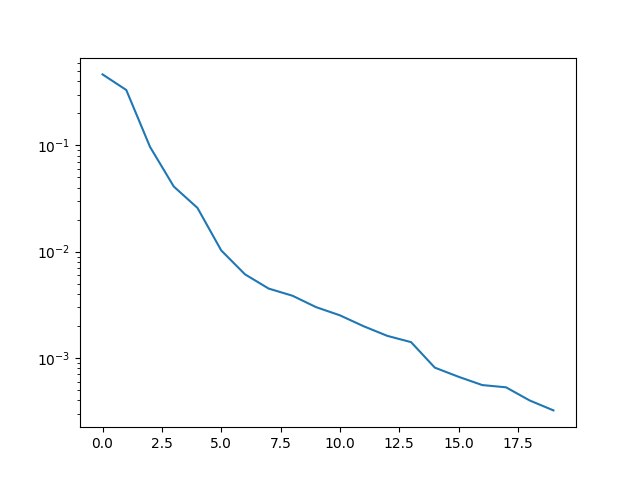

Processing in parallel:   0%|                                                                  | 0/1099 [00:00<?, ?it/s]

local
local
local
local
local
local
SpawnPoolWorker-10SpawnPoolWorker-8 8
 10
CUDA_VISIBLE_DEVICES=CUDA_VISIBLE_DEVICES=  00

SpawnPoolWorker-7 7SpawnPoolWorker-11 
11
CUDA_VISIBLE_DEVICES= 0
CUDA_VISIBLE_DEVICES= 0
SpawnPoolWorker-9 9
CUDA_VISIBLE_DEVICES= 0
SpawnPoolWorker-12 12
CUDA_VISIBLE_DEVICES= 0


Processing in parallel:   2%|█▏                                                       | 24/1099 [00:57<38:06,  2.13s/it]

New solver/alternative transit parameters fallback for planet id 94572221


Processing in parallel:   3%|█▌                                                       | 29/1099 [01:06<35:18,  1.98s/it]

New solver/alternative transit parameters fallback for planet id 128610134
New solver/alternative transit parameters fallback for planet id 152245846


Processing in parallel:   3%|█▌                                                       | 30/1099 [01:17<44:42,  2.51s/it]

New solver/alternative transit parameters fallback for planet id 155501234


Processing in parallel:   3%|█▊                                                       | 34/1099 [01:26<43:48,  2.47s/it]

New solver/alternative transit parameters fallback for planet id 166602615


Processing in parallel:   5%|██▉                                                      | 56/1099 [01:55<31:34,  1.82s/it]

New solver/alternative transit parameters fallback for planet id 205266886


Processing in parallel:   6%|███▋                                                     | 70/1099 [02:22<31:05,  1.81s/it]

New solver/alternative transit parameters fallback for planet id 237793157


Processing in parallel:   7%|████▏                                                    | 80/1099 [02:41<31:08,  1.83s/it]

New solver/alternative transit parameters fallback for planet id 291916399


Processing in parallel:   8%|████▍                                                    | 86/1099 [03:00<34:44,  2.06s/it]

New solver/alternative transit parameters fallback for planet id 342072318


Processing in parallel:   9%|█████                                                    | 97/1099 [03:09<29:35,  1.77s/it]

New solver/alternative transit parameters fallback for planet id 365832854


Processing in parallel:  15%|████████▍                                               | 165/1099 [04:59<24:51,  1.60s/it]

New solver/alternative transit parameters fallback for planet id 656960256


Processing in parallel:  15%|████████▋                                               | 170/1099 [05:06<24:01,  1.55s/it]

New solver/alternative transit parameters fallback for planet id 691402002


Processing in parallel:  19%|██████████▋                                             | 209/1099 [06:12<24:25,  1.65s/it]

New solver/alternative transit parameters fallback for planet id 824937040


Processing in parallel:  24%|█████████████▍                                          | 263/1099 [07:38<22:01,  1.58s/it]

New solver/alternative transit parameters fallback for planet id 1042982756


Processing in parallel:  24%|█████████████▌                                          | 267/1099 [07:46<22:46,  1.64s/it]

New solver/alternative transit parameters fallback for planet id 1053204615


Processing in parallel:  28%|███████████████▌                                        | 305/1099 [08:46<20:31,  1.55s/it]

New solver/alternative transit parameters fallback for planet id 1196027041


Processing in parallel:  29%|████████████████▌                                       | 324/1099 [09:24<22:14,  1.72s/it]

New solver/alternative transit parameters fallback for planet id 1267010874


Processing in parallel:  30%|████████████████▌                                       | 325/1099 [09:25<22:11,  1.72s/it]

New solver/alternative transit parameters fallback for planet id 1267583899


Processing in parallel:  30%|████████████████▊                                       | 329/1099 [09:32<21:53,  1.71s/it]

New solver/alternative transit parameters fallback for planet id 1293223638


Processing in parallel:  30%|████████████████▊                                       | 331/1099 [09:46<25:22,  1.98s/it]

New solver/alternative transit parameters fallback for planet id 1304336843


Processing in parallel:  31%|█████████████████                                       | 336/1099 [09:53<24:20,  1.91s/it]

New solver/alternative transit parameters fallback for planet id 1311109479
New solver/alternative transit parameters fallback for planet id 1329906799


Processing in parallel:  31%|█████████████████▌                                      | 345/1099 [10:17<25:42,  2.05s/it]

New solver/alternative transit parameters fallback for planet id 1349926825


Processing in parallel:  32%|█████████████████▉                                      | 351/1099 [10:27<25:01,  2.01s/it]

New solver/alternative transit parameters fallback for planet id 1370040003
Attempting chop
New solver/alternative transit parameters fallback for planet id 1349926825
New solver/alternative transit parameters fallback for planet id 1349926825


Processing in parallel:  35%|███████████████████▊                                    | 390/1099 [11:25<20:24,  1.73s/it]

New solver/alternative transit parameters fallback for planet id 1475386345


Processing in parallel:  36%|███████████████████▉                                    | 391/1099 [11:29<20:53,  1.77s/it]

New solver/alternative transit parameters fallback for planet id 1484787436


Processing in parallel:  37%|████████████████████▊                                   | 408/1099 [12:02<20:50,  1.81s/it]

New solver/alternative transit parameters fallback for planet id 1547333761


Processing in parallel:  37%|████████████████████▉                                   | 412/1099 [12:05<19:48,  1.73s/it]

New solver/alternative transit parameters fallback for planet id 1554618542


Processing in parallel:  38%|█████████████████████                                   | 414/1099 [12:09<19:54,  1.74s/it]

Attempting chop
New solver/alternative transit parameters fallback for planet id 1547333761
Chop used on planet id 1547333761


Processing in parallel:  39%|██████████████████████                                  | 434/1099 [12:47<19:36,  1.77s/it]

New solver/alternative transit parameters fallback for planet id 1648240892


Processing in parallel:  41%|██████████████████████▉                                 | 450/1099 [13:19<19:39,  1.82s/it]

New solver/alternative transit parameters fallback for planet id 1728792101


Processing in parallel:  44%|████████████████████████▊                               | 486/1099 [14:14<16:52,  1.65s/it]

New solver/alternative transit parameters fallback for planet id 1834181716


Processing in parallel:  46%|█████████████████████████▋                              | 505/1099 [14:45<16:10,  1.63s/it]

New solver/alternative transit parameters fallback for planet id 1888287398


Processing in parallel:  49%|███████████████████████████▋                            | 543/1099 [15:48<15:14,  1.64s/it]

New solver/alternative transit parameters fallback for planet id 2069619536


Processing in parallel:  50%|███████████████████████████▊                            | 547/1099 [15:52<14:18,  1.55s/it]

New solver/alternative transit parameters fallback for planet id 2074730139


Processing in parallel:  50%|███████████████████████████▉                            | 548/1099 [15:56<15:16,  1.66s/it]

New solver/alternative transit parameters fallback for planet id 2083890050
New solver/alternative transit parameters fallback for planet id 2097642218


Processing in parallel:  50%|███████████████████████████▉                            | 549/1099 [16:04<17:11,  1.88s/it]

New solver/alternative transit parameters fallback for planet id 2101537217


Processing in parallel:  52%|█████████████████████████████▏                          | 572/1099 [16:40<14:46,  1.68s/it]

New solver/alternative transit parameters fallback for planet id 2179829794


Processing in parallel:  53%|█████████████████████████████▌                          | 579/1099 [16:53<14:51,  1.71s/it]

New solver/alternative transit parameters fallback for planet id 2225060379


Processing in parallel:  53%|█████████████████████████████▌                          | 580/1099 [17:06<17:39,  2.04s/it]

New solver/alternative transit parameters fallback for planet id 2254664280
New solver/alternative transit parameters fallback for planet id 2259395627


Processing in parallel:  59%|█████████████████████████████████                       | 649/1099 [18:48<11:59,  1.60s/it]

New solver/alternative transit parameters fallback for planet id 2495453637


Processing in parallel:  61%|█████████████████████████████████▉                      | 667/1099 [19:17<11:17,  1.57s/it]

New solver/alternative transit parameters fallback for planet id 2562716556


Processing in parallel:  61%|██████████████████████████████████▏                     | 671/1099 [19:26<11:39,  1.63s/it]

New solver/alternative transit parameters fallback for planet id 2572567064


Processing in parallel:  65%|████████████████████████████████████▌                   | 717/1099 [20:39<10:01,  1.57s/it]

New solver/alternative transit parameters fallback for planet id 2760210399


Processing in parallel:  70%|███████████████████████████████████████▏                | 770/1099 [22:07<08:55,  1.63s/it]

New solver/alternative transit parameters fallback for planet id 3046329646


Processing in parallel:  70%|███████████████████████████████████████▍                | 774/1099 [22:12<08:30,  1.57s/it]

New solver/alternative transit parameters fallback for planet id 3062170297


Processing in parallel:  71%|███████████████████████████████████████▌                | 776/1099 [22:25<10:10,  1.89s/it]

New solver/alternative transit parameters fallback for planet id 3098975946
New solver/alternative transit parameters fallback for planet id 3126879162


Processing in parallel:  73%|█████████████████████████████████████████               | 806/1099 [23:09<08:02,  1.65s/it]

New solver/alternative transit parameters fallback for planet id 3188116178


Processing in parallel:  74%|█████████████████████████████████████████▏              | 809/1099 [23:16<08:11,  1.70s/it]

New solver/alternative transit parameters fallback for planet id 3206727630


Processing in parallel:  77%|███████████████████████████████████████████▎            | 851/1099 [24:24<06:46,  1.64s/it]

New solver/alternative transit parameters fallback for planet id 3344833436


Processing in parallel:  78%|███████████████████████████████████████████▌            | 854/1099 [24:28<06:40,  1.63s/it]

New solver/alternative transit parameters fallback for planet id 3356770267


Processing in parallel:  78%|███████████████████████████████████████████▌            | 856/1099 [24:42<07:41,  1.90s/it]

New solver/alternative transit parameters fallback for planet id 3378847201


Processing in parallel:  78%|███████████████████████████████████████████▊            | 860/1099 [24:49<07:34,  1.90s/it]

New solver/alternative transit parameters fallback for planet id 3398839958


Processing in parallel:  80%|████████████████████████████████████████████▉           | 881/1099 [25:18<06:10,  1.70s/it]

New solver/alternative transit parameters fallback for planet id 3469305332


Processing in parallel:  85%|███████████████████████████████████████████████▍        | 932/1099 [26:36<04:16,  1.53s/it]

New solver/alternative transit parameters fallback for planet id 3653339152


Processing in parallel:  85%|███████████████████████████████████████████████▋        | 936/1099 [26:43<04:12,  1.55s/it]

New solver/alternative transit parameters fallback for planet id 3679528633


Processing in parallel:  88%|█████████████████████████████████████████████████▏      | 965/1099 [27:30<03:23,  1.52s/it]

New solver/alternative transit parameters fallback for planet id 3786449677


Processing in parallel:  90%|██████████████████████████████████████████████████▍     | 990/1099 [28:16<03:03,  1.68s/it]

New solver/alternative transit parameters fallback for planet id 3884695798


Processing in parallel:  91%|██████████████████████████████████████████████████▊     | 996/1099 [28:25<02:52,  1.68s/it]

New solver/alternative transit parameters fallback for planet id 3928265625
Attempting chop
New solver/alternative transit parameters fallback for planet id 3884695798
Attempting chop
Chop used on planet id 3884695798
New solver/alternative transit parameters fallback for planet id 3928265625
New solver/alternative transit parameters fallback for planet id 3955853901
New solver/alternative transit parameters fallback for planet id 3965882786


Processing in parallel:  91%|██████████████████████████████████████████████████▊     | 998/1099 [28:46<03:44,  2.22s/it]

Chop used on planet id 3928265625


Processing in parallel:  95%|████████████████████████████████████████████████████   | 1041/1099 [29:39<01:31,  1.58s/it]

New solver/alternative transit parameters fallback for planet id 4087358670


Processing in parallel:  98%|█████████████████████████████████████████████████████▋ | 1072/1099 [30:30<00:43,  1.62s/it]

New solver/alternative transit parameters fallback for planet id 4220529965


Processing in parallel:  98%|█████████████████████████████████████████████████████▉ | 1077/1099 [30:34<00:32,  1.48s/it]

New solver/alternative transit parameters fallback for planet id 4232767776


Processing in parallel:  99%|██████████████████████████████████████████████████████▌| 1091/1099 [31:02<00:13,  1.63s/it]

New solver/alternative transit parameters fallback for planet id 4293108648


Processing in parallel: 100%|███████████████████████████████████████████████████████| 1099/1099 [31:20<00:00,  1.71s/it]


Opt time 1928.3188970088959
PCA3, no FGS, rescale 0.6
Score:           0.6433
RMS error FGS:   178.25161 ppm
mRMS error FGS:  48.55608 ppm
RMS error AIRS:  150.79801 ppm
mRMS error AIRS: 47.76277 ppm
RMS error AIRSv: 68.19770 ppm
mRMS error AIRSv:29.68717 ppm
(0.6433359095053056, 0.00017825160908276828, 0.00015079801126671692)


In [14]:

kgs.sanity_checks_active = False
print('Sanity checks off!')
def fname(k):
    return kgs.temp_dir + 'evaluate_model_'+k+'__'+str(len(train_data))+'.pickle'
for k,v in todo.items():
    if not os.path.isfile(fname(k)):
        print(k)
        model = copy.deepcopy(v)
       # model.model.run_in_parallel = False
#         print('!!! also loader')
        #if k=='Run on new simple reg kepler fudge_var adjust_u':
            
        #model_ref = kgs.dill_load(fname('All + multifudge'))[2]
        #model._cached_planet_id = model_ref._cached_planet_id
        #model._cached_result = model_ref._cached_result
            # model.bias_a = model_ref.bias_a
            # model.bias_b = model_ref.bias_b
            # model.sigma_fudge_FGS = model_ref.sigma_fudge[0]
            # model.sigma_fudge_AIRS_mean = model_ref.sigma_fudge[1]
            # model.sigma_fudge_AIRS_var = model_ref.sigma_fudge[1]
        
        # Precache data
        #print('precache off')
        #for d in tqdm(train_data):
        #    copy.deepcopy(d).load_to_step(5,model.model.starter_model.loaders)
        
        
        
        #model.state=1
        model.train(train_data)
        #kgs.list_attrs(model)
        inferred_data = model.infer(train_data)
        print(k)
        print(kgs.score_metric(inferred_data, train_data))
        #print('not saving')
        #kgs.list_attrs(model)
        #if k=='Baseline':
        kgs.dill_save(fname(k), (inferred_data,train_data,model,kgs.git_commit_id))
        #print(inferred_data[0].spectrum[0], inferred_data[0].spectrum_cov[0,0])
        #print(inferred_data[-1].spectrum[0], inferred_data[-1].spectrum_cov[0,0])
    else:
        print(k)
        (inferred_data,train_data_here,model,_) = kgs.dill_load(fname(k))
        #print(model.model.model_options.FGS_order)
        print(kgs.score_metric(inferred_data, train_data_here))

In [6]:
%matplotlib widget
ignore_bad_planets = False
def filter_bad_data(data):
    data_out = []
    for d in data:
        if not d.planet_id in [1349926825, 3786449677, 2554492145, 1267010874, 94572221, 2270815333, 3649218579, 576917580, 2154305089, 2207815333, 2740910036]:
            data_out.append(d)
    return data_out
        
def basics():
    plt.grid(True)
    plt.box(True)
def plot_two_sensors(func, xl, yl, mod):
    _,ax = plt.subplots(1,2,figsize=(12,6))
    plt.sca(ax[0]);basics()
    plt.title('FGS')
    plt.xlabel(xl)
    plt.ylabel(yl)
    sc=func(slice(0,1), 'blue', 'FGS')
    mod()
    kgs.add_cursor(sc)
    
    plt.sca(ax[1]);basics()
    plt.title('AIRS')
    plt.xlabel(xl)
    sc=func(slice(1,283), 'red', 'AIRS')
    mod()
    kgs.add_cursor(sc)
    
    plt.pause(0.001)

def report_extreme_ratios(x,y,name):
    return    
    print(name)
    inds = np.argsort(np.abs(y/x))[::-1]
    for ii in inds[:2]:
        print(f'{inferred_data[ii].planet_id}, ratio:{np.abs(y[ii]/x[ii]):.3f}, x:{x[ii]:.3e}, y:{y[ii]:.3e}, RMS:{kgs.rms(error_matrix[ii,:]):.3e}')
    
    
fname_list = [fname(k) for k in todo.keys()]
#fname_list = ['evaluate_model_Baseline__989.pickle', 'evaluate_model_Baseline__110.pickle', 'evaluate_model_Multi-transit__110.pickle']
for f in fname_list:
    (inferred_data,train_data_here,model,_) = kgs.dill_load(f)
    if ignore_bad_planets:
        inferred_data = filter_bad_data(inferred_data)
        train_data_here = filter_bad_data(train_data_here)
    else:
        train_data_here = train_data_here
    #model.bias_a[0]+=0.006
    #model.bias_a[1]-=0.0002
    #inferred_data = model.infer(train_data)
    
    
    print(f)
    print(model.bias_a)
    print(model.bias_b)
    print(model.sigma_offset)
    print(model.sigma_fudge_FGS, model.sigma_fudge_AIRS_mean, model.sigma_fudge_AIRS_var)
    print('mul', model.sigma_fudge_multi)
    
    print(kgs.score_metric(inferred_data, train_data_here,print_results=True))
    print('')
    
    
    
    
    #try:
    #    print(model.sigma_offset)
    #except: pass
    #print(model.sigma_fudge)    
    #kgs.list_attrs(model)
    #kgs.score_metric(inferred_data, train_data_here)
    print('')
    #print('3')
    #kgs.score_metric(inferred_data[:3], train_data_here[:3]) 
    #print('')
    # print('No fudge')
    # #model.sigma_fudge = [1,1]
    # #try: model.sigma_offset = [0,0]
    # #except: pass
    # #model.bias_a = [1,1]
    # #model.bias_b = [0,0]
    # # print('!!!')
    # model.sigma_offset = [0,0]
    # model.sigma_fudge_FGS = 1.
    # model.sigma_fudge_AIRS_mean = 1.
    # model.sigma_fudge_AIRS_var = 1.
    # inferred_data = model.infer(train_data_here)
    #if ignore_bad_planets:
    #    inferred_data = filter_bad_data(inferred_data)
    #kgs.score_metric(inferred_data, train_data_here)     
    error_matrix = np.array([d.spectrum - t.spectrum for d,t in zip(inferred_data,train_data_here)])
    true_matrix = np.array([t.spectrum for d,t in zip(inferred_data,train_data_here)])
    
    continue
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = [d.transit_params.Rs for d in train_data_here]
        y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
        #y = np.mean(error_matrix[:,slic],1)
        sc=plt.scatter(x,y,color = col)
        #print(y[934])
        report_extreme_ratios(x,y,name)    
        return sc
    plot_two_sensors(plot_mean_error_vs_sigma, 'Rs', 'Prediction error / sigma (mean)', lambda:0)
    def plot_mean_error_vs_sigma(slic,col, name):
        x = [d.transit_params.Ts for d in train_data_here]
        y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
        #y = np.mean(error_matrix[:,slic],1)
        sc=plt.scatter(x,y,color = col)
        #print(y[934])
        report_extreme_ratios(x,y,name)    
        return sc
    plot_two_sensors(plot_mean_error_vs_sigma, 'Ts', 'Prediction error / sigma (mean)', lambda:0)
    def plot_mean_error_vs_sigma(slic,col, name):
        x = [d.transit_params.Mp for d in train_data_here]
        y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
        #y = np.mean(error_matrix[:,slic],1)
        sc=plt.scatter(x,y,color = col)
        #print(y[934])
        report_extreme_ratios(x,y,name)    
        return sc
    plot_two_sensors(plot_mean_error_vs_sigma, 'Mp', 'Prediction error / sigma (mean)', lambda:0)
    def plot_mean_error_vs_sigma(slic,col, name):
        x = [d.transit_params.Ms for d in train_data_here]
        y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
        #y = np.mean(error_matrix[:,slic],1)
        sc=plt.scatter(x,y,color = col)
        #print(y[934])
        report_extreme_ratios(x,y,name)    
        return sc
    plot_two_sensors(plot_mean_error_vs_sigma, 'Ms', 'Prediction error / sigma (mean)', lambda:0)
    
    continue
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = [len(d.transits) for d in inferred_data]
        y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
        #y = np.mean(error_matrix[:,slic],1)
        sc=plt.scatter(x,y,color = col)
        #print(y[934])
        report_extreme_ratios(x,y,name)    
        return sc
    plot_two_sensors(plot_mean_error_vs_sigma, 'Number of transits', 'Prediction error / sigma (mean)', lambda:0)
    
    #conintue
    
    def plot_prediction_vs_true(slic, col, name):
        x = np.mean(true_matrix[:,slic],1)
        y = np.mean(error_matrix[:,slic],1)
        sc=plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)
        return sc
        
    plot_two_sensors(plot_prediction_vs_true, 'True value (mean)', 'Prediction error (mean)', lambda:0)
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = [np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data]
        y = np.mean(error_matrix[:,slic],1)
        sc=plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)
        return(sc)
    def mod():
        plt.axline((0,0), slope=3, color='black')
        plt.axline((0,0), slope=-3, color = 'black')        
    plot_two_sensors(plot_mean_error_vs_sigma, 'Sigma prediction (mean)', 'Prediction error (mean)', mod)
    
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = np.mean(true_matrix[:,slic],1)
#         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#         plt.scatter(x,y,color = col)
#         report_extreme_ratios(x,y,name)    
#     plot_two_sensors(plot_mean_error_vs_sigma, 'True value (mean)', 'Prediction error / sigma (mean)', lambda:0)
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = np.std(true_matrix[:,1:],1)
        y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
        #y = np.mean(error_matrix[:,slic],1)
        sc=plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)    
        return sc
    plot_two_sensors(plot_mean_error_vs_sigma, 'AIRS variation', 'Prediction error / sigma (mean)', lambda:0)
    

    
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = [d.diagnostics['simple_residual_diff_AIRS'] for d in inferred_data]
#         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#         #y = np.mean(error_matrix[:,slic],1)
#         sc=plt.scatter(x,y,color = col)
#         report_extreme_ratios(x,y,name)    
#         return sc
#     plot_two_sensors(plot_mean_error_vs_sigma, 'AIRS residual ratio', 'Prediction error / sigma (mean)', lambda:0)
    
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = [d.diagnostics['simple_residual_diff_FGS'] for d in inferred_data]
#         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#         #y = np.mean(error_matrix[:,slic],1)
#         sc=plt.scatter(x,y,color = col)
#         #print(y[934])
#         report_extreme_ratios(x,y,name)    
#         return sc
#     plot_two_sensors(plot_mean_error_vs_sigma, 'FGS residual ratio', 'Prediction error / sigma (mean)', lambda:0)
    
    plt.figure(); basics()
    plt.title('AIRS variation per planet')
    plt.xlabel('Sigma prediction')
    plt.ylabel('STD error')
    n=282
    x=np.sqrt([(np.trace(d.spectrum_cov[1:,1:]) - np.sum(d.spectrum_cov[1:,1:]) / n) / n for d in inferred_data])
    y=np.sqrt(np.var(error_matrix[:,1:],1))
    plt.scatter(x, y, color='red')
    plt.axline((0,0), slope=1, color='black')
    report_extreme_ratios(x,y,'AIRS variation')    
    plt.pause(0.001)
    
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = np.mean(true_matrix[:,slic],1)
#         y = np.sqrt(np.var(error_matrix[:,1:],1)) / np.sqrt([(np.trace(d.spectrum_cov[1:,1:]) - np.sum(d.spectrum_cov[1:,1:]) / n) / n for d in inferred_data])
#         plt.scatter(x,y,color = col)
#         report_extreme_ratios(x,y,name)    
#     plot_two_sensors(plot_mean_error_vs_sigma, 'True value (mean)', 'Prediction error / sigma (AIRS variation)', lambda:0)
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = np.std(true_matrix[:,1:],1)
        y = np.sqrt(np.var(error_matrix[:,1:],1)) / np.sqrt([(np.trace(d.spectrum_cov[1:,1:]) - np.sum(d.spectrum_cov[1:,1:]) / n) / n for d in inferred_data])
        sc=plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)    
        return sc
    plot_two_sensors(plot_mean_error_vs_sigma, 'AIRS variation', 'Prediction error / sigma (AIRS variation)', lambda:0)
    
    
    
    for ii in range(len(inferred_data[0].diagnostics['transit_params_gp_par'])):
        def plot_mean_error_vs_sigma(slic,col, name):
            x = [d.diagnostics['transit_params_gp_par'][ii] for d in inferred_data]
            y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
            #y = np.mean(error_matrix[:,slic],1)
            sc=plt.scatter(x,y,color = col)
            #print(y[934])
            report_extreme_ratios(x,y,name)    
            return sc
        plot_two_sensors(plot_mean_error_vs_sigma, f'Transit param {ii}', 'Prediction error / sigma (mean)', lambda:0)
    
    continue
    
    # for ii in range(7):
    #     if ii==4:
    #         continue
    #     def plot_mean_error_vs_sigma(slic,col, name):
    #         x = [d.diagnostics['transit_params_gp'][0].to_x()[ii] for d in inferred_data]
    #         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
    #         #y = np.mean(error_matrix[:,slic],1)
    #         sc=plt.scatter(x,y,color = col)
    #         #print(y[934])
    #         report_extreme_ratios(x,y,name)    
    #         return sc
    #     plot_two_sensors(plot_mean_error_vs_sigma, f'Transit param FGS {ii}', 'Prediction error / sigma (mean)', lambda:0)
        
    # for ii in np.arange(5,7):
    #     def plot_mean_error_vs_sigma(slic,col, name):
    #         x = [d.diagnostics['transit_params_gp'][1].to_x()[ii] for d in inferred_data]
    #         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
    #         #y = np.mean(error_matrix[:,slic],1)
    #         sc=plt.scatter(x,y,color = col)
    #         #print(y[934])
    #         report_extreme_ratios(x,y,name)    
    #         return sc
    #     plot_two_sensors(plot_mean_error_vs_sigma, f'Transit param AIRS {ii}', 'Prediction error / sigma (mean)', lambda:0)
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = [d.diagnostics['transit_params_gp'][1].t0-d.diagnostics['transit_params_gp'][0].t0 for d in inferred_data]
        y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
        #y = np.mean(error_matrix[:,slic],1)
        sc=plt.scatter(x,y,color = col)
        #print(y[934])
        report_extreme_ratios(x,y,name)    
        return sc
    plot_two_sensors(plot_mean_error_vs_sigma, f't0 diff', 'Prediction error / sigma (mean)', lambda:0)
    
    mat = np.stack([d.diagnostics['transit_params_gp_par'] for d in inferred_data])[:,:,0]
    mat.shape
    
    plt.figure()
    plt.imshow(np.corrcoef(mat.T))
    plt.colorbar()
    sns.pairplot(pd.DataFrame(mat), diag_kind="hist", corner=True, height=1.5)
    
    for ii in range(inferred_data[0].diagnostics['transit_params_gp_par_cov'].shape[0]):
        plt.figure()
        plt.plot( np.sqrt([d.diagnostics['transit_params_gp_par_cov'][ii,ii] for d in inferred_data]))
        plt.title(ii-1)
        #plt.plot( np.sqrt([d.diagnostics['transit_params_gp_par_cov'][6,6] for d in inferred_data]))
    for ii in range(2):
        for jj in range(7):
            if jj==4:
                continue
            x = [d.diagnostics['transit_params'][ii].to_x()[jj] for d in inferred_data]
            y = [d.diagnostics['transit_params_gp'][ii].to_x()[jj] for d in inferred_data]
            plt.figure()
            plt.scatter(x,y)
            plt.title(str(ii) + ' ' + str(jj))
            plt.xlabel('Simple')
            plt.ylabel('GP')
            plt.axline((x[0],x[0]), slope=1, color='black')

/mnt/d//ariel2/temp/evaluate_model_PCA2 no FGS__1099.pickle
[1.0000744464076525, 0.9990058278625842]
[7.073548378589384e-05, 0.00017466965162626384]
[1.1695085054655563e-05, -1.4168865646341462e-08]
1.9281419804724798 2.1892983602988965 0.9946658693667868
mul 1.0
Score:           0.6395
RMS error FGS:   176.95381 ppm
mRMS error FGS:  49.17191 ppm
RMS error AIRS:  148.84194 ppm
mRMS error AIRS: 51.52673 ppm
RMS error AIRSv: 63.16145 ppm
mRMS error AIRSv:33.26288 ppm
(0.6394791776366413, 0.00017695381101481706, 0.00014884193729224575)


/mnt/d//ariel2/temp/evaluate_model_PCA3 no FGS__1099.pickle
[1.0000847386508918, 0.9989870897626936]
[7.34104095359635e-05, 0.0001762242438738763]
[8.338240733077404e-06, -8.290143107931937e-09]
2.0384829279275487 2.2109894134921846 1.0067501905624348
mul 1.0
Score:           0.6442
RMS error FGS:   177.99670 ppm
mRMS error FGS:  48.91289 ppm
RMS error AIRS:  147.12815 ppm
mRMS error AIRS: 46.79901 ppm
RMS error AIRSv: 59.55848 ppm
mRMS error AIRSv:28.099

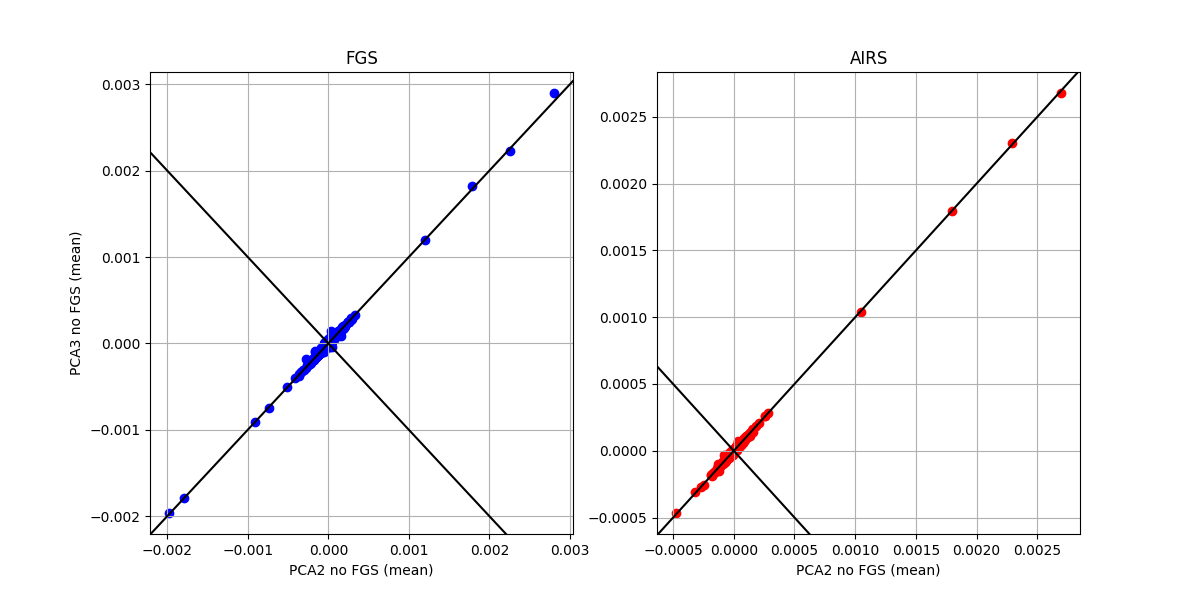

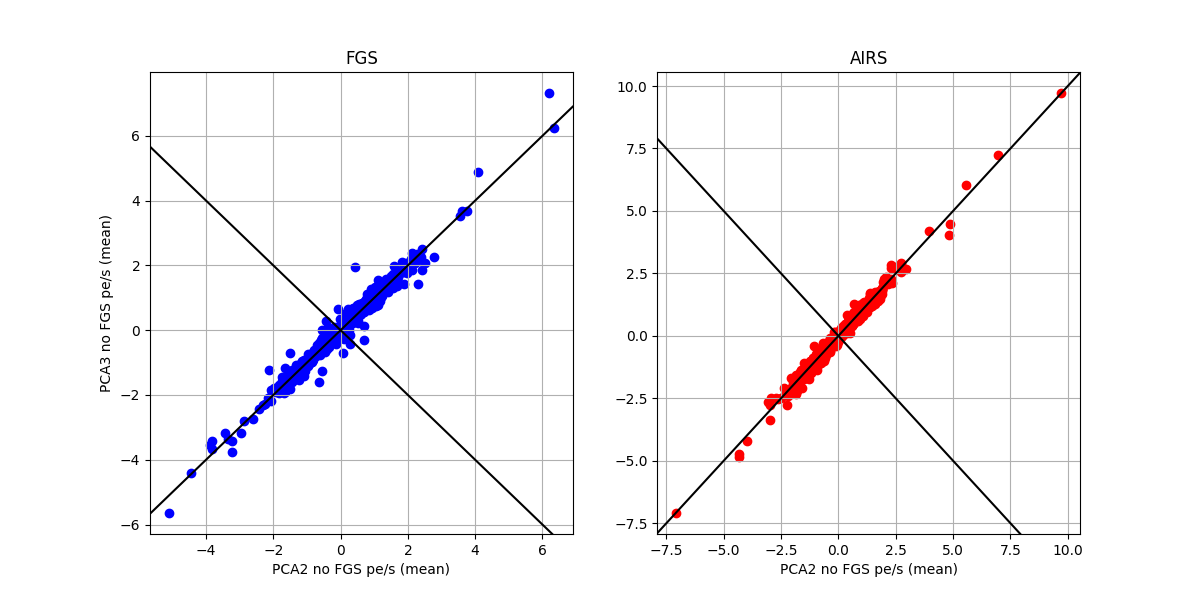

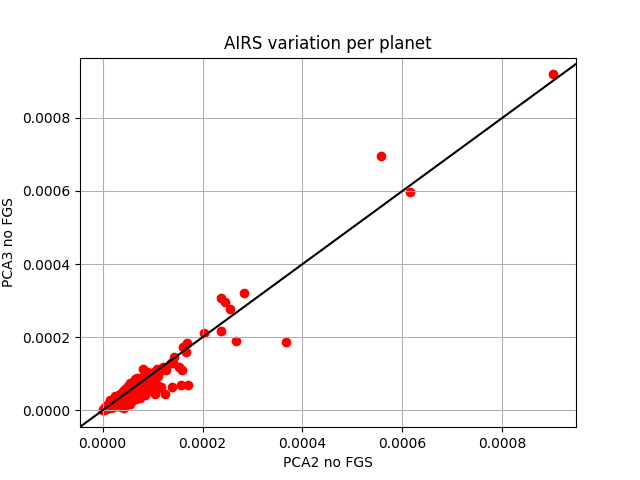

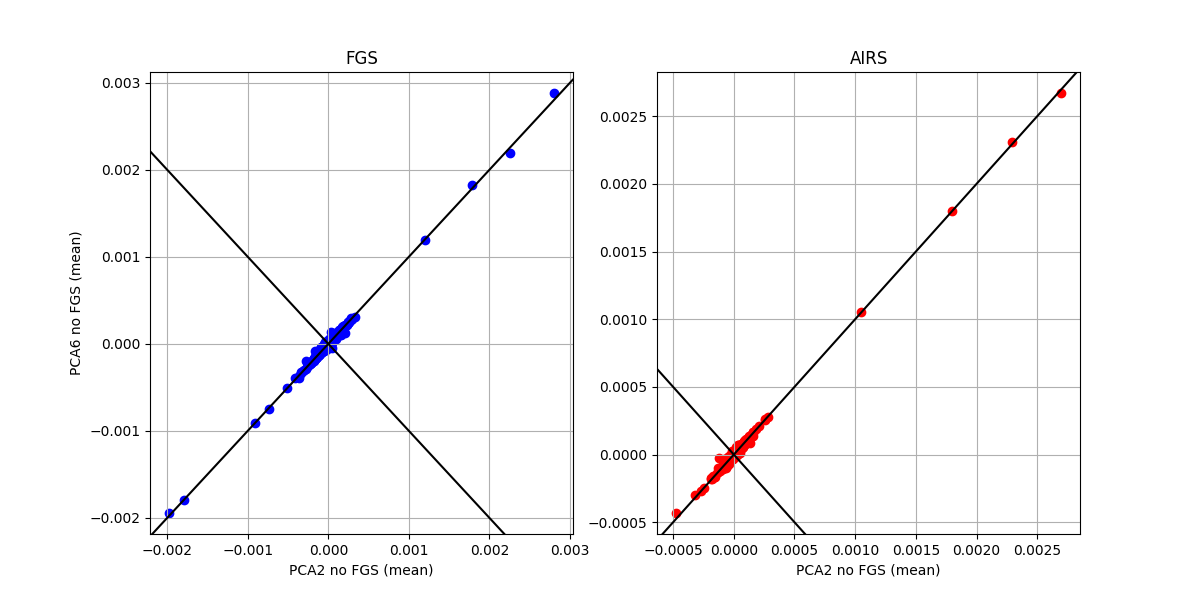

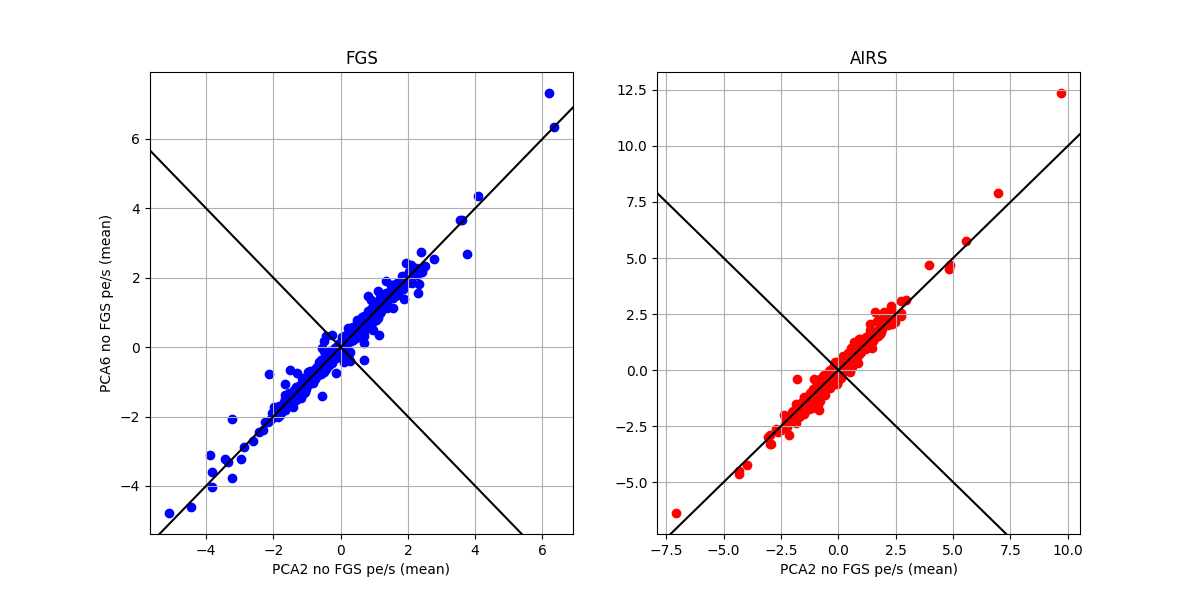

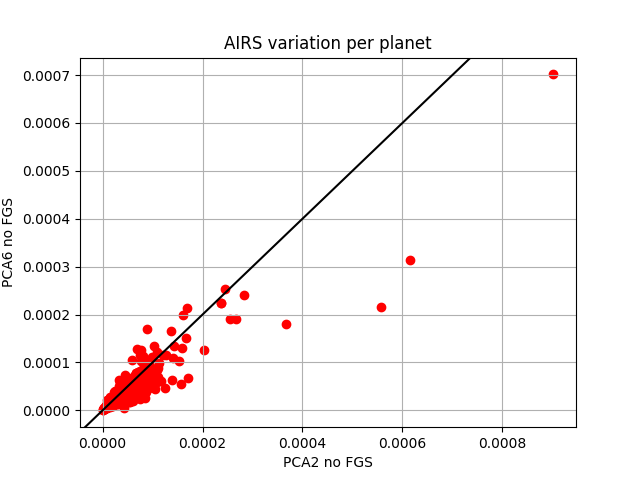

In [7]:
compare1= list(todo.keys())[0]
data1 = kgs.dill_load(fname(compare1))[0]
if ignore_bad_planets:
    data1 = filter_bad_data(data1)
for k,v in todo.items():    
    compare2= k
    if compare2==compare1:
        continue    
    data2 = kgs.dill_load(fname(compare2))[0]
    if ignore_bad_planets:
        data2 = filter_bad_data(data2)
        train_data_here = filter_bad_data(train_data)
    else:
        train_data_here = train_data           
    error1 = np.array([d.spectrum - t.spectrum for d,t in zip(data1,train_data_here)])
    error2 = np.array([d.spectrum - t.spectrum for d,t in zip(data2,train_data_here)])
    def plot_prediction_vs_true(slic, col, name):
        x = np.mean(error1[:,slic],1)
        y = np.mean(error2[:,slic],1)
        sc=plt.scatter(x,y,color = col)
        #kgs.add_cursor(sc)
        return sc

    plot_two_sensors(plot_prediction_vs_true, compare1+' (mean)', compare2+' (mean)', lambda:(plt.axline((0,0),slope=1,color='black'),plt.axline((0,0),slope=-1,color='black')))
    
    def plot_prediction_vs_true(slic, col, name):
        x = np.mean(error1[:,slic],1)/np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in data1])
        y = np.mean(error2[:,slic],1)/np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in data2])
        #print(x[934],y[934])
        sc=plt.scatter(x,y,color = col)
        return sc
        #kgs.add_cursor(sc)
    plot_two_sensors(plot_prediction_vs_true, compare1+' pe/s (mean)', compare2+' pe/s (mean)', lambda:(plt.axline((0,0),slope=1,color='black'),plt.axline((0,0),slope=-1,color='black')))
    
#     continue
    
#     for ii in range(2):
#         for jj in range(7):
#             if jj==4:
#                 continue
#             # x = [d.diagnostics['transit_params'][ii].to_x()[jj] for d in data1]
#             # y = [d.diagnostics['transit_params'][ii].to_x()[jj] for d in data2]
#             # plt.figure()
#             # sc=plt.scatter(x,y)
#             # plt.axline((x[0],x[0]), slope=1, color='black')
#             # plt.xlabel(compare1)
#             # plt.ylabel(compare2)
#             # plt.title(str(ii) + ' ' + str(jj))
#             # plt.grid(True)
#             # kgs.add_cursor(sc)
#             x = [d.diagnostics['transit_params_gp'][ii].to_x()[jj] for d in data1]
#             y = [d.diagnostics['transit_params_gp'][ii].to_x()[jj] for d in data2]
#             plt.figure()
#             sc=plt.scatter(x,y)
#             plt.axline((x[0],x[0]), slope=1, color='black')
#             plt.xlabel(compare1)
#             plt.ylabel(compare2)
#             plt.title(str(ii) + ' ' + str(jj) + ' gp')
#             plt.grid(True)
#             kgs.add_cursor(sc)
            
#     x = [d.diagnostics['simple_residual_diff_FGS'] for d in data1]
#     y = [d.diagnostics['simple_residual_diff_FGS'] for d in data2]
#     plt.figure()
#     plt.scatter(x,y)
#     plt.axline((x[0],x[0]), slope=1, color='black')
#     plt.xlabel(compare1)
#     plt.ylabel(compare2)
#     plt.title('FGS residual')
#     plt.grid(True)
    
#     x = [d.diagnostics['simple_residual_diff_AIRS'] for d in data1]
#     y = [d.diagnostics['simple_residual_diff_AIRS'] for d in data2]
#     plt.figure()
#     plt.scatter(x,y)
#     plt.axline((x[0],x[0]), slope=1, color='black')
#     plt.xlabel(compare1)
#     plt.ylabel(compare2)
#     plt.title('AIRS residual')
#     plt.grid(True)
            

    plt.figure(); basics()
    plt.title('AIRS variation per planet')
    plt.xlabel(compare1)
    plt.ylabel(compare2)
    x=np.sqrt(np.var(error1[:,1:],1))
    y=np.sqrt(np.var(error2[:,1:],1))
    plt.scatter(x, y, color='red')
    plt.axline((0,0), slope=1, color='black')
    plt.pause(0.001)

In [8]:
# import subprocess

# # Hibernate Windows
# subprocess.run(
#     ["/mnt/c/Windows/System32/shutdown.exe", "/a"],  # add "/f" to force-close apps
#     check=True
# )
# subprocess.run(
#     ["/mnt/c/Windows/System32/shutdown.exe", "/h"],  # add "/f" to force-close apps
#     check=True
# )

/home/jcottaar/miniconda3/envs/xlab/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jcottaar/miniconda3/envs/xlab/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jcottaar/miniconda3/envs/xlab/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jcottaar/miniconda3/envs/xlab/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

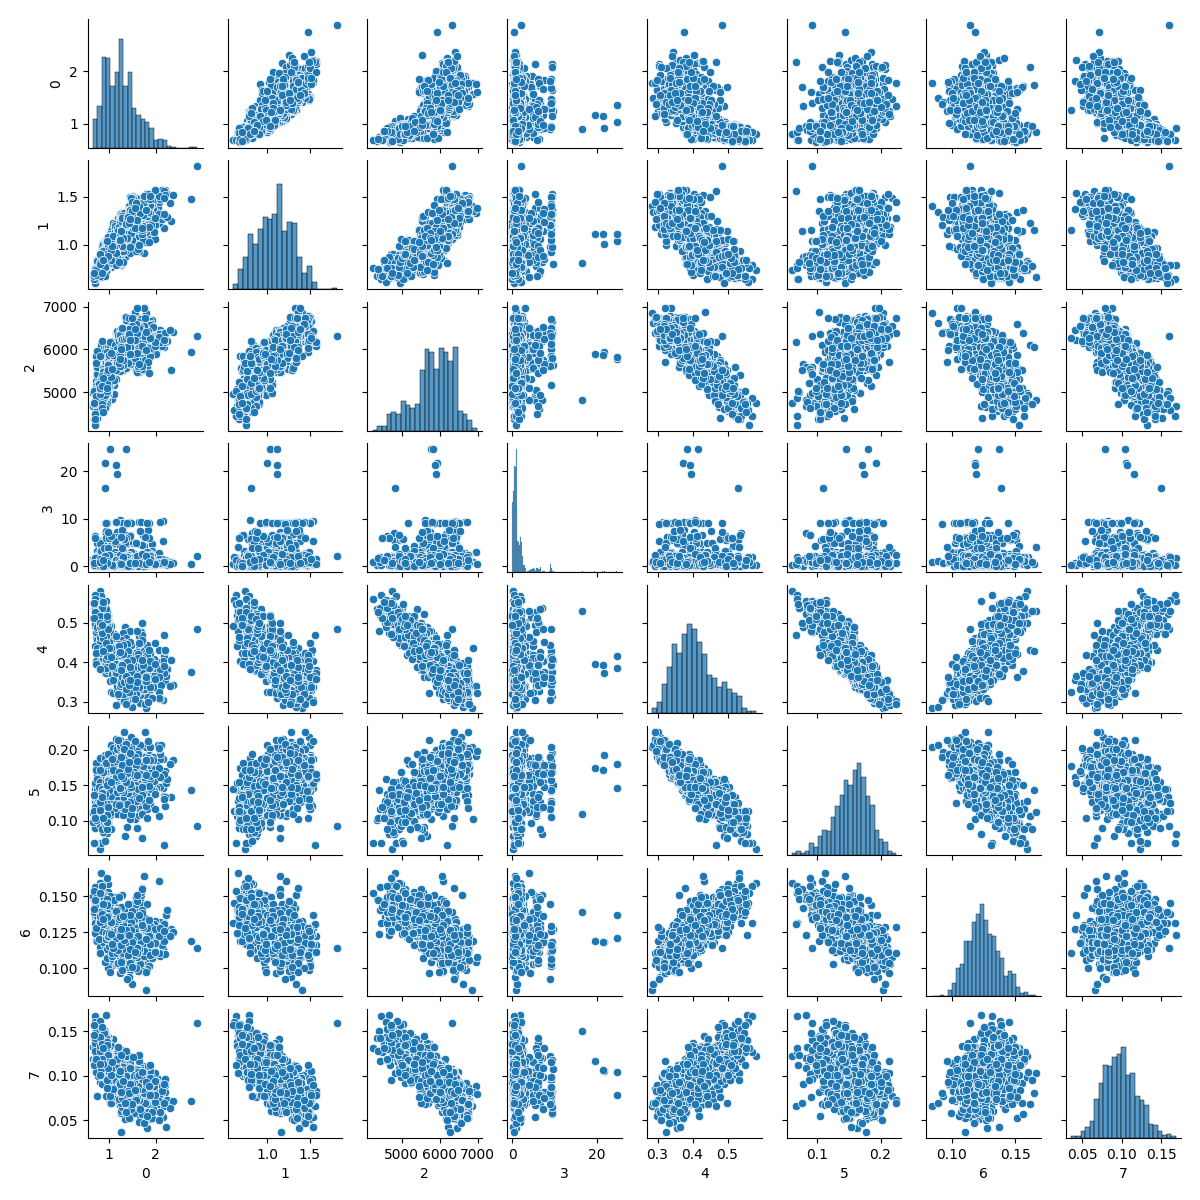

In [9]:
data_alt = copy.deepcopy(inferred_data)
res = []
for d,t in zip(data_alt, train_data):
    for ii in range(2):
        x = d.diagnostics['transit_params_gp'][ii].to_x()
        d.diagnostics['transit_params_gp'][ii].Rs = t.transit_params.Rs
        d.diagnostics['transit_params_gp'][ii].Ms = t.transit_params.Ms
        d.diagnostics['transit_params_gp'][ii].Ts = t.transit_params.Ts
        d.diagnostics['transit_params_gp'][ii].Mp = t.transit_params.Mp
        d.diagnostics['transit_params_gp'][ii].from_x(x)
    this_res=np.zeros(8)
    this_res[0] = d.diagnostics['transit_params_gp'][0].Rs
    this_res[1] = d.diagnostics['transit_params_gp'][0].Ms
    this_res[2] = d.diagnostics['transit_params_gp'][0].Ts
    this_res[3] = d.diagnostics['transit_params_gp'][0].Mp
    this_res[4] = d.diagnostics['transit_params_gp'][0].u[0]
    this_res[5] = d.diagnostics['transit_params_gp'][0].u[1]
    this_res[6] = d.diagnostics['transit_params_gp'][1].u[0]
    this_res[7] = d.diagnostics['transit_params_gp'][1].u[1]
    res.append(this_res)
sns.pairplot(pd.DataFrame(res), diag_kind="hist", corner=False, height=1.5)

In [10]:
data_alt[0].transit_params

TransitParams(comment='', Rs=1.155435480707952, Ms=1.062960837903184, Ts=5577.006645157513, Mp=0.6949463499730458, e=0.0, w=90.0, Rp=0.0, P=79.33413003895987, t0=None, sma=8.550785903749272, i=89.1507586203837, Rp_fudge=1.0, limb_dark='quadratic', u=None, expose_e_and_w=False, force_kepler=False, expose_Rp_fudge=False)

In [11]:
res= np.array(res)
y = res[:,6:7]
X= res[:,[2]]
#X= np.concatenate((res[:,[2]], np.ones((res.shape[0],1))),1)

import statsmodels.api as sm
X_norm = (X - np.mean(X,0)) / np.std(X,0)
X = np.concatenate((X, np.ones((res.shape[0],1))),1)
#X_norm = X
#X_const = sm.add_constant(X_norm)
model = sm.OLS(y,X).fit()
print(model.summary())
kgs.rms(y-np.mean(y)),kgs.rms(model.predict(X)[:,None]-y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     937.0
Date:                Tue, 16 Sep 2025   Prob (F-statistic):          2.95e-149
Time:                        08:48:24   Log-Likelihood:                 3594.1
No. Observations:                1099   AIC:                            -7184.
Df Residuals:                    1097   BIC:                            -7174.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.661e-05   5.43e-07    -30.611      0.0

(0.012518867544830605, 0.009193707832500888)

In [12]:
kgs.rms(y-np.mean(y)),kgs.rms(model.predict(X_norm)-y)

ValueError: shapes (1099,1) and (2,) not aligned: 1 (dim 1) != 2 (dim 0)

In [ ]:
res[0:3,:].shape, np.ones((4,1)).shape

In [ ]:
res.shape

In [ ]:
X_norm.shape, np.ones((res.shape[0],1)).shape

In [ ]:
np.mean(X,0)

In [ ]:
y.shape

In [ ]:
model.predict(X_norm).shape